In [72]:
import os
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import geopandas as gpd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [73]:
data_dir = './data/'

fig_x = 20
fig_y = 30

BATCH_SIZE = 1

learning_rates = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]

In [74]:
#
# Global warming: monthly temperature anomaly
# The combined land-surface air and sea-surface water temperature anomaly is given as the deviation from the 1951 - 1980 mean.
# Source: https://ourworldindata.org/explorers/climate-change?facet=none&country=~OWID_WRL&Metric=Temperature+anomaly&Long-run+series%3F=false
#

#
# Global warming: monthly sea surface temperature anomaly
# This is measured at a nominal depth of 20cm, and given relative to the average temperature from the period of 1961 - 1990.
# Source: https://ourworldindata.org/explorers/climate-change?facet=none&country=~OWID_WRL&Metric=Sea+surface+temperature+anomaly&Long-run+series%3F=false
#

df1 = pd.read_csv(data_dir + 'climate-change-air.csv', low_memory=False)
df1.drop(df1[df1.Entity != 'World'].index, inplace=True)
df1.drop(columns=['Code', 'Entity'], inplace=True)
df1.rename(columns={'temperature_anomaly': 'world_air_temperature_anomaly'}, inplace=True)

df2 = pd.read_csv(data_dir + 'climate-change-sea.csv', low_memory=False)
df2.drop(df2[df2.Entity != 'World'].index, inplace=True)
df2.drop(columns=['Code', 'Entity'], inplace=True)
df2.rename(columns={'monthly_sea_surface_temperature_anomaly': 'world_sea_temperature_anomaly'}, inplace=True)

df = df1.merge(df2, on="Day", how = 'inner')
print(df.head())
print(df.shape[0])

          Day  world_air_temperature_anomaly  world_sea_temperature_anomaly
0  1880-01-15                          -0.18                        -0.2283
1  1880-02-15                          -0.24                        -0.1353
2  1880-03-15                          -0.08                        -0.0102
3  1880-04-15                          -0.16                        -0.1158
4  1880-05-15                          -0.09                        -0.3387
1701


In [75]:
df.head()

,Day,world_air_temperature_anomaly,world_sea_temperature_anomaly
0,1880-01-15,-0.18,-0.2283
1,1880-02-15,-0.24,-0.1353
2,1880-03-15,-0.08,-0.0102
3,1880-04-15,-0.16,-0.1158
4,1880-05-15,-0.09,-0.3387


In [76]:
df.drop(columns=['Day', 'world_sea_temperature_anomaly'], inplace=True)
df.head()

,world_air_temperature_anomaly
0,-0.18
1,-0.24
2,-0.08
3,-0.16
4,-0.09


In [77]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [78]:
numpy.random.seed(7)

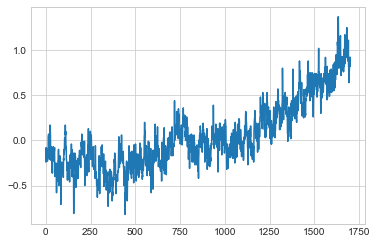

In [79]:
dataset = df.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

In [80]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [81]:
#
# Split into train and test sets - 70% 30%
#

train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print('Train size: ' + str(len(train)))
print('Test size: ' + str(len(test)))

Train size: 1190
Test size: 511


In [82]:
# Convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        
    return numpy.array(dataX), numpy.array(dataY)

In [83]:
#
# Reshape into X=t and Y=t+1
#

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [84]:
#
# Reshape input to be [samples, time steps, features]
#

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [85]:
learning_rates = [0.001, 0.0001] #, 0.00001]  #, 0.000001, 0.0000001]

In [86]:
#
# Create LSTM model
#

def create_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, epochs):
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))

    opt = Adam(learning_rate=lrate)
    model.compile(loss=loss_type, optimizer=opt, metrics=['accuracy'])
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=BATCH_SIZE, verbose=1, validation_data=(testX, testY))  # Batch size TBD start with 1 for now
    
    return history, model

Epoch 1/100
1188/1188 [==============================] - 2s 1ms/step - loss: 0.0057 - accuracy: 8.4175e-04 - val_loss: 0.0227 - val_accuracy: 0.0020
Epoch 2/100
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0030 - accuracy: 8.4175e-04 - val_loss: 0.0072 - val_accuracy: 0.0020
Epoch 3/100
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0028 - accuracy: 8.4175e-04 - val_loss: 0.0052 - val_accuracy: 0.0020
Epoch 4/100
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0027 - accuracy: 8.4175e-04 - val_loss: 0.0041 - val_accuracy: 0.0020
Epoch 5/100
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0028 - accuracy: 8.4175e-04 - val_loss: 0.0048 - val_accuracy: 0.0020
Epoch 6/100
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0028 - accuracy: 8.4175e-04 - val_loss: 0.0054 - val_accuracy: 0.0020
Epoch 7/100
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0027 - accuracy: 8.4175e-04

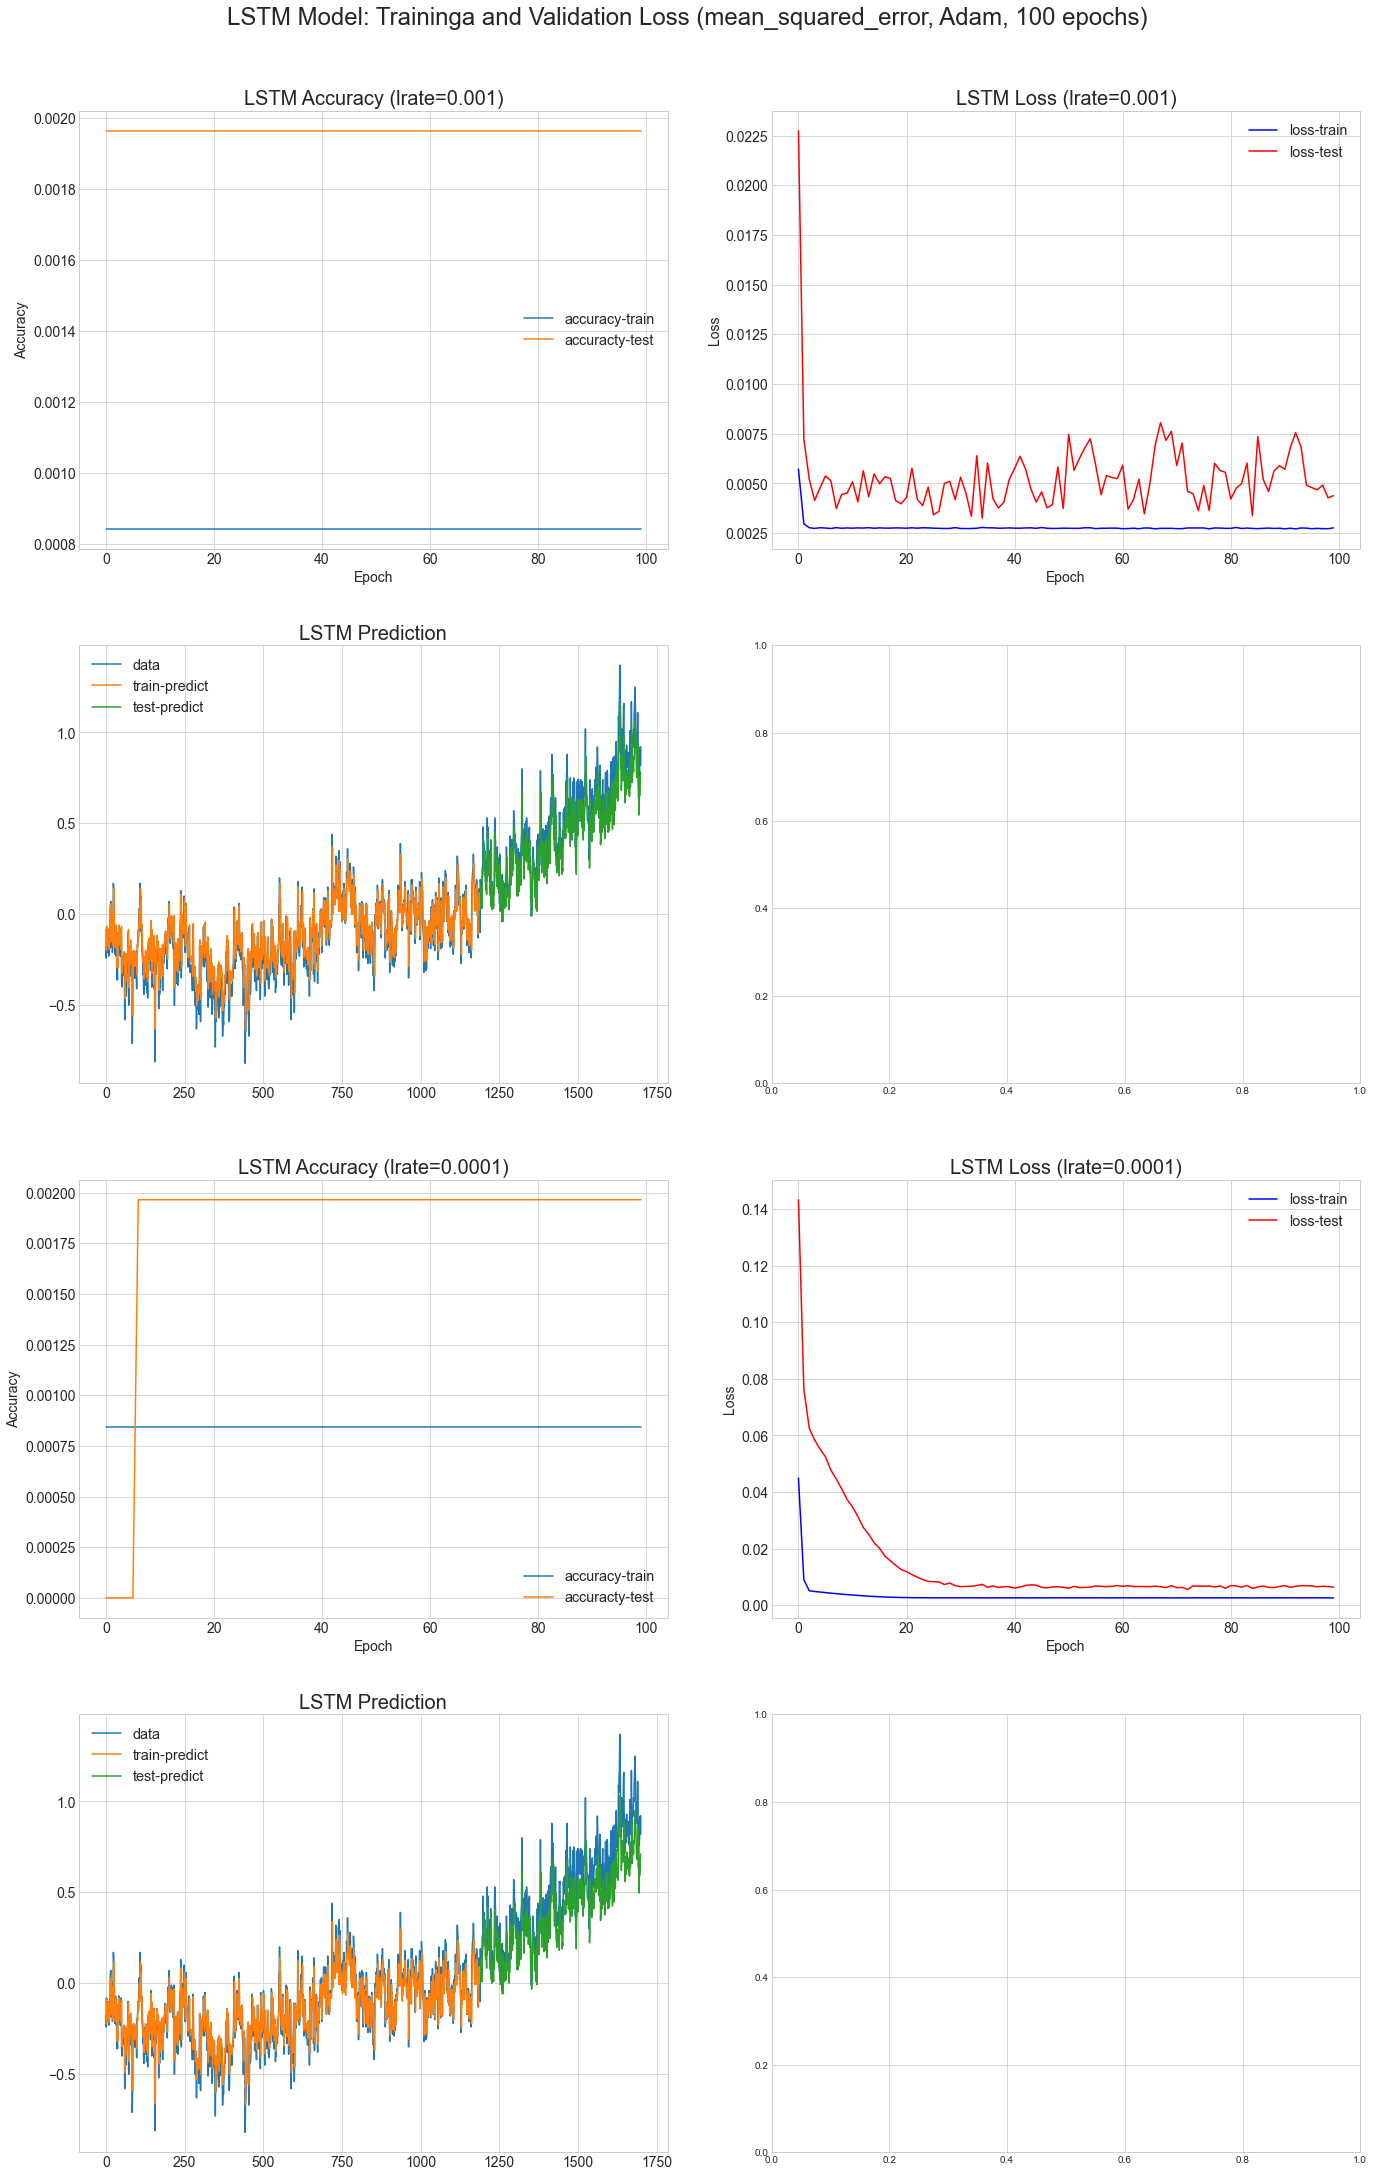

In [88]:
#
# Try different learning rates for Adam
#

plt.style.use('seaborn-whitegrid')
f, ax = plt.subplots(len(learning_rates) * 2, 2, figsize=(fig_x, fig_y));

row = 0
col = 0
cnt = 0

for lrate in learning_rates:
    
    history_lstm, lstm_model = create_lstm_model(trainX, trainY, testX, testY, lrate, 'mean_squared_error', 100)
    
    #
    # Predictions
    #
    trainPredict = lstm_model.predict(trainX)
    testPredict = lstm_model.predict(testX)

    #
    # Invert predictions back using the scalar
    #
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_orig = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_orig = scaler.inverse_transform([testY])

    #
    # Calculate root mean squared error
    #
    trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    #
    # shift train predictions for plotting
    #
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    #
    # shift test predictions for plotting
    #
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
    if col == 2:
        col = 0
        row += 1

    epochs = range(len(history_lstm.history['loss']))

    ax[row,col].plot(epochs, history_lstm.history['accuracy'], label='accuracy-train')
    ax[row,col].plot(epochs, history_lstm.history['val_accuracy'], label='accuracty-test')
    ax[row,col].set_title('LSTM Accuracy (lrate=' + str(lrate) + ')', fontsize=20)
    ax[row,col].legend(fontsize='x-large')
    ax[row,col].tick_params(axis='both', labelsize=14)
    ax[row,col].set_xlabel('Epoch', fontsize=14)
    ax[row,col].set_ylabel('Accuracy', fontsize=14)
    
    col += 1

    ax[row,col].plot(epochs, history_lstm.history['loss'], "b", label='loss-train')
    ax[row,col].plot(epochs, history_lstm.history['val_loss'], "r", label='loss-test')
    ax[row,col].set_title('LSTM Loss (lrate=' + str(lrate) + ')', fontsize=20)
    ax[row,col].legend(fontsize='x-large')
    ax[row,col].tick_params(axis='both', labelsize=14)
    ax[row,col].set_xlabel('Epoch', fontsize=14)
    ax[row,col].set_ylabel('Loss', fontsize=14)
    
    col += 1
    
    #
    # Plot predictions
    #

    row += 1
    
    ax[row,0].plot(scaler.inverse_transform(dataset), label="data")  # Blue
    ax[row,0].plot(trainPredictPlot, label='train-predict')  # Orange
    ax[row,0].plot(testPredictPlot, label='test-predict')   # Green
    ax[row,0].set_title('LSTM Prediction', fontsize=20)
    ax[row,0].legend(fontsize='x-large')
    ax[row,0].tick_params(axis='both', labelsize=14)
    ax[row,0].set_xlabel('', fontsize=14)
    ax[row,0].set_ylabel('', fontsize=14)
    
    #score_lstm = lstm_model.evaluate(testX, testY, verbose=1)
    #print('Loss: {}'.format(score_lstm[0]))
    #print('Accuracy: {}'.format(score_lstm[1]*100))

f.tight_layout(pad=4.0);
f.suptitle('LSTM Model: Air Climate Change - Traininga and Validation Loss (mean_squared_error, Adam, 100 epochs)', y=1.02, fontsize=24)
plt.show();   

### **Create Main Dataframe**
#### Using ALL datasets

In [6]:
#
# Apply method for each dataset's dataframe
#
def update_master_df(row):
    
    global df_main
    
    country = row['Country Code']
    code = row['Indicator Code']
    
    d = []
    
    for y in range(1960, 2021, 1):
        if str(y) in row:
            d.append(row[str(y)])
        else:
            d.append(float("NaN"))
    
    df_main[country + '_' + code] = d
    
      

file_names = [
    'API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_3053855.csv',     # Access to electricity (% of population) EG.ELC.ACCS.ZS
    'API_AG.LND.AGRI.ZS_DS2_en_csv_v2_3052884.csv',     # Agricultural land (% of land area) AG.LND.AGRI.ZS
    'API_AG.LND.ARBL.ZS_DS2_en_csv_v2_3054826.csv',     # Arable land (% of land area) AG.LND.ARBL.ZS
    'API_EN.ATM.CO2E.PC_DS2_en_csv_v2_3053008.csv',     # CO2 emissions (metric tons per capita) EN.ATM.CO2E.PC
    'API_AG.YLD.CREL.KG_DS2_en_csv_v2_3053734.csv',     # Cereal yield (kg per hectare) AG.YLD.CREL.KG
    'API_EG.USE.ELEC.KH.PC_DS2_en_csv_v2_3052822.csv',  # Electric power consumption (kWh per capita) EG.USE.ELEC.KH.PC
    'API_AG.LND.FRST.ZS_DS2_en_csv_v2_3052585.csv',     # Forest area (% of land area) AG.LND.FRST.ZS
    'API_AG.LND.EL5M.ZS_DS2_en_csv_v2_3057029.csv',     # Land area where elevation is below 5 meters (% of total land area) AG.LND.EL5M.ZS
    'API_SH.DYN.MORT_DS2_en_csv_v2_3058030.csv',        # Mortality rate, under-5 (per 1,000 live births) SH.DYN.MORT
    'API_SP.POP.GROW_DS2_en_csv_v2_3052790.csv',        # Population growth (annual %) SP.POP.GROW
    'API_EN.POP.EL5M.ZS_DS2_en_csv_v2_3057452.csv',     # Population living in areas where elevation is below 5 meters (% of total population) EN.POP.EL5M.ZS
    'API_SI.POV.DDAY_DS2_en_csv_v2_3055766.csv',        # Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population) SI.POV.DDAY
    'API_SE.PRM.CMPT.ZS_DS2_en_csv_v2_3053767.csv',     # Primary completion rate, total (% of relevant age group) SE.PRM.CMPT.ZS
    'API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_3053509.csv',     # Renewable energy consumption (% of total final energy consumption) EG.FEC.RNEW.ZS
    'API_SP.URB.TOTL_DS2_en_csv_v2_3058363.csv',        # Urban population SP.URB.TOTL
    'API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_3052981.csv',     # Agriculture, forestry, and fishing, value added (% of GDP) NV.AGR.TOTL.ZS
    'API_EN.ATM.CO2E.KT_DS2_en_csv_v2_3052647.csv',     # CO2 emissions (kt) EN.ATM.CO2E.KT
    'API_EG.USE.PCAP.KG.OE_DS2_en_csv_v2_3052915.csv',  # Energy use (kg of oil equivalent per capita) EG.USE.PCAP.KG.OE
    'API_AG.LND.FRST.K2_DS2_en_csv_v2_3054052.csv',     # Forest area (sq. km) AG.LND.FRST.K2
    'API_EN.ATM.METH.KT.CE_DS2_en_csv_v2_3052859.csv',  # Methane emissions (kt of CO2 equivalent) EN.ATM.METH.KT.CE
    'API_EN.ATM.NOXE.KT.CE_DS2_en_csv_v2_3054894.csv',  # Nitrous oxide emissions (thousand metric tons of CO2 equivalent) EN.ATM.NOXE.KT.CE
    'API_EN.URB.MCTY.TL.ZS_DS2_en_csv_v2_3053950.csv',  # Population in urban agglomerations of more than 1 million (% of total population) EN.URB.MCTY.TL.ZS
    'API_SP.POP.TOTL_DS2_en_csv_v2_3052518.csv',        # Population, total SP.POP.TOTL
    'API_SH.STA.MALN.ZS_DS2_en_csv_v2_3058087.csv',     # Prevalence of underweight, weight for age (% of children under 5) SH.STA.MALN.ZS
    'API_EG.ELC.RNEW.ZS_DS2_en_csv_v2_3054878.csv',     # Renewable electricity output (% of total electricity output) EG.ELC.RNEW.ZS
    'API_SE.ENR.PRSC.FM.ZS_DS2_en_csv_v2_3057870.csv',  # School enrollment, primary and secondary (gross), gender parity index (GPI) SE.ENR.PRSC.FM.ZS
    'API_EN.ATM.GHGT.KT.CE_DS2_en_csv_v2_3052850.csv',  # Total greenhouse gas emissions (kt of CO2 equivalent) EN.ATM.GHGT.KT.CE
    'API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_3053985.csv'   # Urban population (% of total population) SP.URB.TOTL.IN.ZS
]


#
# Main dataframe to work off of
#

df_main = pd.DataFrame(columns=['year'])
df_main['year'] = [
    1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
    1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
    1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
    1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
    2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
    2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
    2020
]


#
# Loop through each dataset and add it to the main dataframe
#
c = 0
df_collection = {}
for f in file_names:
    _df = pd.read_csv(data_dir + f)
    _df.drop(columns=['Country Name', 'Indicator Name'], inplace=True)
    _df.drop(_df.columns[_df.columns.str.contains('unnamed', case = False)], axis = 1, inplace = True)
    # _df.info()
    df_collection[c] = _df
    _df.apply(update_master_df, axis=1)             
    c += 1

df_main.head(20)  

,year,ABW_EG.ELC.ACCS.ZS,AFE_EG.ELC.ACCS.ZS,AFG_EG.ELC.ACCS.ZS,AFW_EG.ELC.ACCS.ZS,AGO_EG.ELC.ACCS.ZS,ALB_EG.ELC.ACCS.ZS,AND_EG.ELC.ACCS.ZS,ARB_EG.ELC.ACCS.ZS,ARE_EG.ELC.ACCS.ZS,...,VIR_SP.URB.TOTL.IN.ZS,VNM_SP.URB.TOTL.IN.ZS,VUT_SP.URB.TOTL.IN.ZS,WLD_SP.URB.TOTL.IN.ZS,WSM_SP.URB.TOTL.IN.ZS,XKX_SP.URB.TOTL.IN.ZS,YEM_SP.URB.TOTL.IN.ZS,ZAF_SP.URB.TOTL.IN.ZS,ZMB_SP.URB.TOTL.IN.ZS,ZWE_SP.URB.TOTL.IN.ZS
0,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,56.477,14.700,10.404,33.617972,18.926,NaN,9.100,46.619,18.145,12.608
1,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57.864,15.031,10.583,34.115490,18.986,NaN,9.459,46.793,18.951,12.821
2,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,59.241,15.369,10.765,34.557149,19.061,NaN,9.831,46.906,19.785,13.082
3,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60.604,15.714,10.950,34.943734,19.141,NaN,10.216,47.020,20.712,13.578
4,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61.952,16.064,11.138,35.336154,19.221,NaN,10.614,47.134,22.015,14.092
5,1965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.279,16.421,11.329,35.556682,19.301,NaN,11.026,47.248,23.372,14.620
6,1966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.587,16.784,11.522,35.753544,19.382,NaN,11.451,47.362,24.789,15.165
7,1967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.874,17.153,11.718,35.963487,19.593,NaN,11.891,47.476,26.261,15.727
8,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67.140,17.529,11.918,36.169563,19.844,NaN,12.347,47.590,27.791,16.306
9,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.378,17.911,12.120,36.365600,20.097,NaN,12.815,47.704,29.370,16.880
